In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm
!pip install torchsr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00


In [3]:
import os
import timm

import csv

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

import torchsr

import numpy as np
import pandas as pd

import torchvision
from torchvision import tv_tensors, transforms
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms import v2 as T
from torchvision.transforms import Grayscale, ToPILImage, ToTensor
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.models as models
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import ImageFolder

import seaborn as sns
from sklearn.metrics import confusion_matrix

from skimage import exposure
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Classes and Functions definitions

In [4]:
class CustomClassifierModel(nn.Module):

  def __init__(self, num_classes, model_type):
    super(CustomClassifierModel, self).__init__()
    self.model_type = model_type

    if self.model_type == 'eff':
      self.model = timm.create_model("efficientnet_b0", pretrained=True)
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Linear(in_features, num_classes)

    if self.model_type == 'resnet18':
      self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)
    if self.model_type == 'resnet50':
      self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
      in_features = self.resnet.fc.in_features
      self.resnet.fc = nn.Linear(in_features, num_classes)
    if self.model_type == 'vgg16':
      self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) #pretrained=True
      self.model.classifier[6] = nn.Linear(4096, num_classes)

    # in_features = self.model.classifier.in_features
    # self.model.classifier = nn.Linear(in_features, num_classes)

  def forward(self, x):
    if self.model_type == 'resnet18': return self.resnet(x)
    if self.model_type == 'resnet50': return self.resnet(x)
    if self.model_type == 'eff': return self.model(x)
    if self.model_type == 'vgg16': return self.model(x)


def detection_model():
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        2,
    )

    return model

In [5]:
#used when image is in tensor form
def show_t(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#used when image is read with PIL
def show(img):
  plt.figure(figsize=(7, 7))
  plt.imshow(img)
  plt.show()

### Inference f

In [6]:
#To change depending on the dataset used in the model training
dict_label = {0 : 'biodegradable', 1 : 'glass', 2 : 'paper', 3 : 'plastic', 4 : 'special', 5 : 'trash'} # MIX-WASTE-PICTURES / TACO
# dict_label = {0 : 'trash', 1 : 'glass', 2 : 'paper', 3 : 'plastic'} # TACO - CROPPED
# dict_label = {0 : 'cardboard', 1 : 'glass', 2 : 'metal', 3 : 'paper', 4 : 'plastic', 5 : 'trash'} # TRASH-NET

#this function is called for each image
def draw_mask_on_image(output_det, image):

  #list of predicted mask of single image
  pred_masks = []

  for pred_mask, score in zip(output_det["masks"], output_det["scores"]):
    #choose trashold to accept or discard a detection
    if score >= 0.8:
      #choose trashold to accept or discard a single pixel in a mask
      bool_pixel = pred_mask > 0.3
      pred_masks.append(bool_pixel)

  c_det = len(pred_masks)
  print('IDENTIFIED OBJECTS: ', c_det)

  if c_det == 0: return [], 0

  #tensor of masks from the predicted masks' list
  masks = torch.stack(pred_masks)

  image_ret = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  image_ret = image_ret[:3, ...]

  #return image with a segmentantion draw on top of original image
  image_seg = draw_segmentation_masks(image_ret.to(torch.uint8), masks.squeeze(1), alpha = 0.5, colors = 'red')

  #show image
  # show_t(image_seg)

  return image_seg, c_det


#this function is called for each image
def extrapolation_bbox(pred_image, image):

  pred_boxes = []
  pred_labels = []
  for label, box, score in zip(pred_image["labels"], pred_image["boxes"], pred_image["scores"]):
    #choose trashold to accept or discard a detection
    if score >= 0.8:
      pred_boxes.append(box.long())
      pred_labels.append(f"trash: {score:.3f}")

  if len(pred_boxes) == 0: return []
  boxes = torch.stack(pred_boxes)

  image_ret = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  image_ret = image_ret[:3, ...]

  #return image with a bounded box draw on top of original image
  output_image = draw_bounding_boxes(image_ret, boxes, pred_labels, colors="red")

  #show image
  # show_t(output_image)

  #return the value of the boxes (1 or more values)
  return boxes

In [7]:

transform1 = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform2 = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

tra = transforms.ToTensor()

# Load models


In [8]:

path_detection_model = '/content/drive/MyDrive/VISIOPE_Project/weights/MaskRCNN_10epochs_4batch_onlytaco'
# MaskRCNN_10epochs_4batch_onlytaco
# MaskRCNN_10epochs_4batch_MJU
# MASKrcnn_TACO_5epochs_batch4

path_classification_model = '/content/drive/MyDrive/VISIOPE_Project/weights/pesi_classification/VGG_MIX_BAL.pth'
# VGG_MIX_BAL.pth
# RES_cropTACO4_notover.pth
# RES_cropTACO.pth
# RES_cropTACO4.pth
# RES_TRASH-NET
# VGG_TRASH-NET
# RES_cropMIX_over.pth
# RES_cropMIX_notover.pth

In [9]:
# load of detection model with our weights
detection_model = detection_model()
detection_model.load_state_dict(torch.load(path_detection_model))
detection_model.to(device)
detection_model.eval()

#load of classification model with our weights
#change the parameter of CustomClassifierModel in way of number of classes and model
classification_model = CustomClassifierModel(6, 'vgg16')
classification_model.load_state_dict(torch.load(path_classification_model))
classification_model.to(device)
classification_model.eval()

sr_model = torchsr.models.edsr(pretrained=True, scale=4)
sr_model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 132MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.3MB/s]
Downloading: "https://github.com/Coloquinte/torchSR/releases/download/v1.0.3/edsr_x4.pt" to /root/.cache/torch/hub/checkpoints/edsr_x4.pt
100%|██████████| 164M/164M [00:01<00:00, 133MB/s]


EDSR(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

## PERFORM INFERENCE ON TEST-LOADER


In [10]:
#path of csv with images test

# data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TRASH-NET/dataset-original/'
data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'
# data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/'

In [11]:
# TO USE WITH TRAINING, VALIDATION AND TEST SETS CSV FILE

class ClassificationDataset(Dataset):
  def __init__(self, csv_file, TACO, TACO4, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform

    # To remove the selected rows
    self.rows_to_remove = []

    if TACO:
      self.root_dir = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/'    #TACO
    else:
      self.root_dir = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'

    if TACO4:
      for idx in range(len(self.data_frame)):
        if self.data_frame.iloc[idx, 4] == 0 or self.data_frame.iloc[idx, 4] == 4:
          #print(self.data_frame.iloc[idx])
          self.rows_to_remove.append(idx)

    # To remove the selected rows
    self.data_frame = self.data_frame.drop(index=self.rows_to_remove)

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    pos_label = 1
    if TACO: pos_label = 4
    img_path = self.data_frame.iloc[idx, 0]
    label = int(self.data_frame.iloc[idx, pos_label])   #4 for taco
    if TACO4 and label == 5:
      label = 0

    # Load image
    image = Image.open(self.root_dir+img_path).convert("RGB")

    # Apply transformations
    if self.transform:
        image = self.transform(image)

    return image, label


class CustomImageFolder(ImageFolder):
  def __init__(self, root, transform=None, target_transform=None):
    # Use init of superclass CustomImageFolder
    super(CustomImageFolder, self).__init__(root, transform, target_transform)

  def __getitem__(self, index):
    path, target = self.samples[index]

    # Print the image path and label during loading
    # print(f"Image path: {path}, Label: {target}")

    # Load image
    img = super(CustomImageFolder, self).__getitem__(index)

    return img

In [12]:
TACO4 = False  #True when we test TACO with 4 classes instead of 6
TACO = False
# test_class_balanced.csv
#taco_for_classification_test
test_dataset = ClassificationDataset(data_dir_path+'test_class_balanced.csv', TACO, TACO4, transform2)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=False)
print(len(test_loader))

# uncomment to do test with trash-net dataset
# custom_dataset = CustomImageFolder(root=data_dir_path, transform=transform2) #cambiare la struttura della cartella

# train_size = int(0.7 * len(custom_dataset))
# val_size = int(0.15 * len(custom_dataset))
# test_size = len(custom_dataset) - train_size - val_size

# # Partiotion of dataset
# train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=False)

490


In [13]:
# Function where we simulate the functionalities of the apllication:
# once the image is read we pass it to detection model that returns the bounded box and the segmentation of the obejct
# we calculate the cropped image and pass it to the super resolution model to improve the resolution of the crops
# we pass the crops to the classification model

# in this case the test's images are in dataloader way

def applicativo_loader(detection_model, classification_model, test_loader):
  c_mis = 0
  c_det = 0

  true_labels = []

  pred_labels = []
  j = 0
  for images, labels in test_loader:
    print(j)
    j += 1

    t_image = images.to(device)

    preds_img = detection_model(t_image[:, :3, :, :])

    for i in range(len(images)):
      print(i)
      image = images[i]
      pred_img = preds_img[i]

      #print(pred_img)

      image_seg, n_det = draw_mask_on_image(pred_img, image)
      c_det += n_det
      if image_seg == []:
        print('NO IMAGE DETECTION')
        continue

      crop_regions = extrapolation_bbox(pred_img, image)
      if crop_regions == []:
        print('NO IMAGE DETECTION')
        continue

      ## START CLASSIFICATION PART

      for region in crop_regions:
        left, top, right, bottom = region
        cropped_image = image[:, top:bottom, left:right].to(device)
        # print(type(cropped_image))

        #pass the cropped image to super resolution model
        cropped_image_sr = sr_model(cropped_image)
        # print(type(cropped_image_sr))

        #to classify the image we use the same image transformation that we used during training phase

        class_image = transform1(cropped_image[ :3, :, :])
        x = class_image.unsqueeze(0).to(device)

        outputs = classification_model(x.float())
        _, predicted = torch.max(outputs.data, 1)
        print(type(predicted))
        print(predicted)
        predicted = predicted.cpu()
        print(predicted[0].item())
        label = int(labels[i])
        if label != predicted[0].item():
          c_mis += 1

        #Show cropped image
        # show_t(cropped_image)
        # show_t(cropped_image_sr)

        #print(img_path)

        print('THE NET PREDICTS', dict_label[predicted[0].item()])
        print('TRUE', dict_label[label])

        #list to Confusion Matix results
        true_labels.append(label)
        pred_labels.append(predicted[0].item())

  print('MISCLASSIFIED OUTPUT : ', c_mis)
  print('NUMBER OF DETECTION : ', c_det)

  return true_labels, pred_labels


true_labels, pred_labels = applicativo_loader(detection_model, classification_model, test_loader)

0
0
IDENTIFIED OBJECTS:  1
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
1
IDENTIFIED OBJECTS:  0
NO IMAGE DETECTION
2
IDENTIFIED OBJECTS:  1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
tensor([4], device='cuda:0')
4
THE NET PREDICTS special
TRUE plastic
3
IDENTIFIED OBJECTS:  1
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
1
0
IDENTIFIED OBJECTS:  4
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
<class 'torch.Tensor'>
tensor([0], device='cuda:0')
0
THE NET PREDICTS biodegradable
TRUE plastic
1
IDENTIFIED OBJECTS:  1
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
2
IDENTIFIED OBJECTS:  2
<class 'torch.Tensor'>
tensor([3], device='cuda:0')
3
THE NET PREDICTS plastic
TRUE plastic
<class 'torch.Tensor'>
tensor([4], device='cuda:0')
4
THE NET PREDICTS special
TRUE plastic
3
IDENTIFIED OBJECTS:  1
<class 'torch.Tensor'>
tensor([3], devi

KeyboardInterrupt: 

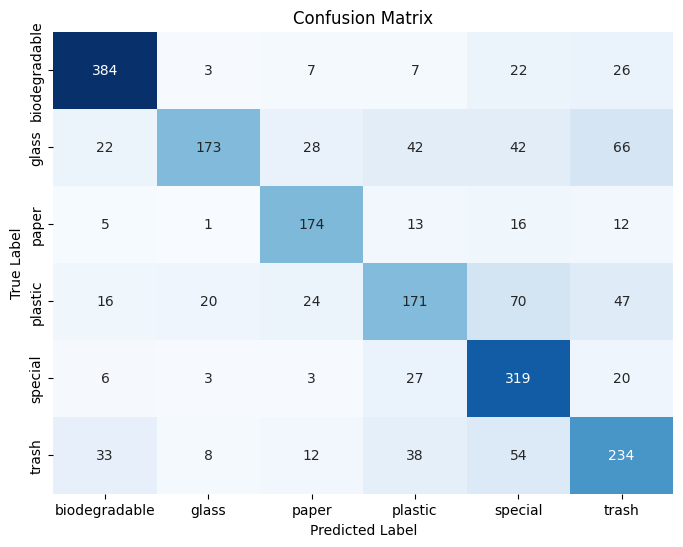

In [ ]:
label = ['biodegradable','glass','paper','plastic', 'special', 'trash'] #mix-waste
# label = ['trash', 'glass', 'paper', 'plastic'] #taco4
# label = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] #trash-net
conf_matrix = confusion_matrix(true_labels, pred_labels)

# TO PLOT CONFUSION MATRIX
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label), yticklabels=np.unique(label)) #pass labels list

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# PERFORM INFERENCE ON TEST-SET CSV


In [ ]:
# as before, but here we pass a csv with the image to test

data_dir_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/CLASSIFICATION_dataset/'
csv_TEST_path = data_dir_path+'test_class_balanced.csv'

def applicativo_csv(detection_model, classification_model, path_csv = None):
  c_mis = 0
  c_det = 0

  df_test = pd.read_csv(path_csv)

  for i in range(len(df_test)):

    img_path = df_test.iloc[i, 0]

    label = int(df_test.iloc[i, 1])   # LABEL ARE IN 4TH POSITION IN TACO CSV

    ## START DETECTION PART

    image = Image.open(data_dir_path+img_path).convert("RGB")
    show(image)
    image_cont = ImageOps.equalize(image)

    image_g = tra(image_cont)
    t_image = image_g.unsqueeze(0).float().to(device)

    pred_img = detection_model(t_image[:, :3, :, :])

    image_seg, n_det = draw_mask_on_image(pred_img[0], image_g)
    c_det += n_det
    if image_seg == []:
      print('NO IMAGE DETECTION')
      continue

    crop_regions = extrapolation_bbox(pred_img[0], image_g)
    if crop_regions == []:
      print('NO IMAGE DETECTION')
      continue

    ## START CLASSIFICATION PART

    for region in crop_regions:
      left, top, right, bottom = region
      cropped_image = image_g[:, top:bottom, left:right]

      cropped_image_sr = sr_model(cropped_image.to(device))

      class_image = transform1(cropped_image[ :3, :, :])
      x = class_image.unsqueeze(0).to(device)

      outputs = classification_model(x.float())
      _, predicted = torch.max(outputs.data, 1)
      predicted = predicted.cpu()

      if label != predicted[0].item():
        c_mis += 1

      # Show cropped image
      show_t(cropped_image)

      print(img_path)
      print('THE NET PREDICTS', dict_label[predicted[0].item()])
      print('TRUE', dict_label[label])

  print('MISCLASSIFIED OUTPUT : ', c_mis)
  print('NUMBER OF DETECTION : ', c_det)


applicativo_csv(detection_model, classification_model, csv_TEST_path)

# INFERENCE ON ONE "NEW" TEST IMAGE

In [ ]:
#same procedure of before, but in this case we pass to the model a single image to test

test_image_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TEST/'
img_path = test_image_path+'13.jpg'

## START DETECTION PART

image = Image.open(img_path).convert("RGB")
width, height = image.size
new_height = 720
new_width = int((new_height / height) * width)
image = image.resize((new_width, new_height))
show(image)
image_cont = ImageOps.equalize(image)

image_g = tra(image_cont)
t_image = image_g.unsqueeze(0).float().to(device)
pred_img = detection_model(t_image[:, :3, :, :])


image_seg = draw_mask_on_image(pred_img[0], image_g)
if image_seg == []:
  print('NO IMAGE DETECTION')
  exit()

crop_regions = extrapolation_bbox(pred_img[0], image_g)
if crop_regions == []:
  print('NO IMAGE DETECTION')
  exit()

## START CLASSIFICATION PART

for region in crop_regions:
  left, top, right, bottom = region
  cropped_image = image_g[:, top:bottom, left:right]

  cropped_image_sr = sr_model(cropped_image.to(device))

  #to classify the image we use the same image transformation that we used during training phase
  class_image = transform1(cropped_image_sr[ :3, :, :])
  x = class_image.unsqueeze(0).to(device)

  outputs = classification_model(x.float())
  _, predicted = torch.max(outputs.data, 1)
  predicted = predicted.cpu()

  # Show cropped image
  show_t(cropped_image)
  show_t(cropped_image_sr)

  print(img_path)
  print('THE NET PREDICTS', dict_label[predicted[0].item()])